# Evn

In [3]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [4]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [5]:
!nvidia-smi

Thu Jan 28 12:13:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 입력 및 Vocab

In [6]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아 나는 오늘 우울해'
]

In [7]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [8]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

train_inputs

array([[2, 3, 4, 5, 2, 3, 6]])

In [9]:
# embedding
embedding = tf.keras.layers.Embedding(len(word_to_id), 4)

In [10]:
# 단어벡터
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(1, 7, 4), dtype=float32, numpy=
array([[[ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
        [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
        [-0.00963336, -0.01013004,  0.01826939,  0.02741292]]],
      dtype=float32)>

# RNN

## return sequence=False, return_state=False

In [11]:
# rnn
rnn_11 = tf.keras.layers.SimpleRNN(units=5)
output_11 = rnn_11(hidden)
print(output_11)

tf.Tensor([[ 0.01330511 -0.07108933  0.01356495  0.19825453 -0.03756266]], shape=(1, 5), dtype=float32)


In [12]:
# rnn weights
weights = rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [13]:
# (return_sequences=True)
rnn_12 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True)
output_12 = rnn_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[ 2.9929113e-02  4.1185715e-03 -7.3335785e-03 -2.7490625e-02
   -4.2592518e-02]
  [ 2.1723522e-02  3.4244333e-03 -8.8698808e-03  1.3401903e-02
   -2.1286130e-02]
  [ 4.8892803e-02 -1.5492365e-02  5.2009197e-03 -5.0389312e-02
   -6.7127943e-02]
  [ 5.3107727e-02  3.3684179e-02  4.7106575e-02  2.6926832e-02
   -1.6819073e-02]
  [ 6.6921934e-02 -6.2528998e-06  3.1169422e-02 -2.7292369e-02
    2.3001328e-02]
  [ 5.5012077e-02 -4.9766432e-02 -4.8280220e-02  2.3197079e-02
    1.8371819e-02]
  [ 1.5149731e-02 -9.3269750e-02  1.8400170e-02  7.5474032e-04
   -6.5119125e-02]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [14]:
# (return_state=True)
rnn_13 = tf.keras.layers.SimpleRNN(units=5, return_state=True)
output_13, fw_h_13 = rnn_13(hidden)  # (bs, units), (bs, units)
print(output_13)
print(fw_h_13)

tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525431 -0.12735648]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.22489886  0.0802756   0.02204562 -0.07525431 -0.12735648]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [15]:
# (return_sequences=True, return_state=True)
rnn_14 = tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14 = rnn_14(hidden)  # (bs, seq, units), (bs, units)
print(output_14)
print(fw_h_14)

tf.Tensor(
[[[-0.00567131  0.00702238  0.0166551  -0.02649674 -0.00639815]
  [ 0.00745121  0.00397363 -0.03161482  0.00067732  0.03525217]
  [ 0.02503373  0.04381724 -0.01435504 -0.07607194 -0.03647323]
  [ 0.03158387 -0.03594298 -0.03295876  0.09170678  0.00911083]
  [-0.06396969  0.06692141  0.02803503 -0.07891871 -0.05069153]
  [ 0.03279418 -0.04417155 -0.0934143   0.03336659  0.09773416]
  [ 0.01325146  0.01543665  0.01574939 -0.08289386 -0.10723302]]], shape=(1, 7, 5), dtype=float32)
tf.Tensor([[ 0.01325146  0.01543665  0.01574939 -0.08289386 -0.10723302]], shape=(1, 5), dtype=float32)


## init hidden state

In [16]:
# rnn_11 with fw_h_13
rnn_11(hidden, initial_state=[fw_h_13]) #(bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.06465909, -0.25594386, -0.12518847,  0.13231514, -0.02561224]],
      dtype=float32)>

In [17]:
# rnn_12 with fw_h_14
rnn_12(hidden, initial_state=[fw_h_14]) #(bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[ 0.08970518,  0.12074085,  0.02214283, -0.00741253,
         -0.06301705],
        [ 0.06890633,  0.02803108,  0.03387965, -0.06119581,
          0.07141122],
        [ 0.13040167, -0.04140751, -0.09347053, -0.06496176,
         -0.03006373],
        [ 0.11627129, -0.0390062 ,  0.06014568, -0.02257582,
         -0.09820992],
        [ 0.14631154,  0.03326441,  0.08039214,  0.05096839,
         -0.02580854],
        [ 0.08789143, -0.0689813 ,  0.05173644,  0.0284674 ,
          0.10066067],
        [ 0.04806692, -0.15309517, -0.0424258 ,  0.05481382,
          0.01750821]]], dtype=float32)>

In [18]:
# rnn_13 with fw_h_13
rnn_13(hidden, initial_state=[fw_h_13]) #(bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090792, -0.01084655,  0.00649465,  0.03989043,  0.08458713]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.16090792, -0.01084655,  0.00649465,  0.03989043,  0.08458713]],
       dtype=float32)>]

In [19]:
# rnn_14 with fw_h_14
rnn_14(hidden, initial_state=[fw_h_14]) # (bs, n_seq, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.04023583, -0.04856527, -0.00745723,  0.08569599,
           0.03263333],
         [-0.03993217,  0.04022601, -0.01334169, -0.12017839,
           0.01704528],
         [ 0.08773063, -0.04925723, -0.03939972, -0.01440457,
           0.00531509],
         [-0.01835137,  0.00441734,  0.04440122,  0.04724794,
          -0.07235701],
         [-0.06754462,  0.03039354,  0.00770029, -0.0223841 ,
           0.06637929],
         [ 0.07404423, -0.00928033, -0.04943877, -0.06849187,
           0.0399126 ],
         [ 0.03545615, -0.01660539,  0.01871963,  0.0433761 ,
          -0.07521319]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.03545615, -0.01660539,  0.01871963,  0.0433761 , -0.07521319]],
       dtype=float32)>]

# LSTM

## return sequence=False, return_state=False

In [20]:
# lstm
lstm_11 = tf.keras.layers.LSTM(units=5)
output_11 = lstm_11(hidden) # (bs, units)
print(output_11)

tf.Tensor([[ 0.01252829 -0.01186483 -0.01100006  0.00128962  0.00689079]], shape=(1, 5), dtype=float32)


In [21]:
# lstm weights
weights = lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)
print(Wh.shape)
print(b.shape)

(4, 20)
(5, 20)
(20,)


## return sequence=True, return_state=False

In [22]:
# (return_sequences=True)
lstm_12 = tf.keras.layers.LSTM(units=5, return_sequences=True)
output_12 = lstm_12(hidden)  # (bs, seq, units)
print(output_12)

tf.Tensor(
[[[-0.00544438 -0.00505095  0.00146407 -0.00019775 -0.00408297]
  [ 0.00092337  0.00106309 -0.00256752  0.00214575 -0.00409309]
  [-0.00466804 -0.00234009 -0.00467812  0.00283395 -0.01177095]
  [-0.00136526  0.00112071 -0.00880492  0.00172207 -0.00966276]
  [-0.00722189 -0.00401254 -0.00514568  0.00093245 -0.01217542]
  [-0.00101654  0.00202121 -0.00762216  0.00274471 -0.01070324]
  [ 0.00060078  0.00327611 -0.0104871   0.00319098 -0.00986872]]], shape=(1, 7, 5), dtype=float32)


## return sequence=False, return_state=True

In [23]:
# (return_state=True)
lstm_13 = tf.keras.layers.LSTM(units=5, return_state=True)
output_13, fw_h_13, fw_c_13 = lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)

tf.Tensor(
[[ 7.6129856e-03 -1.5287819e-02  7.3035900e-03  4.7373163e-05
   1.1121374e-02]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[ 7.6129856e-03 -1.5287819e-02  7.3035900e-03  4.7373163e-05
   1.1121374e-02]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[ 1.5119703e-02 -3.0797768e-02  1.4539111e-02  9.5065981e-05
   2.2492619e-02]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [24]:
# (return_sequences=True, return_state=True)
lstm_14 = tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True)
output_14, fw_h_14, fw_c_14 = lstm_14(hidden) # (bs, seq, units), (bs, units), (bs, units)
print(fw_h_14)
print(fw_c_14)

tf.Tensor([[-0.00361855 -0.00470538  0.00690782 -0.00543057 -0.0025354 ]], shape=(1, 5), dtype=float32)
tf.Tensor([[-0.00723413 -0.0093214   0.01380899 -0.01084147 -0.00508808]], shape=(1, 5), dtype=float32)


## init hidden state

In [25]:
# lstm_11 with fw_h_13, fw_c_13
lstm_11(hidden, initial_state=[fw_h_13, fw_c_13]) # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.01215497, -0.01394067, -0.01243899,  0.00035355,  0.00925507]],
      dtype=float32)>

In [26]:
# lstm_12 with fw_h_14, fw_c_14
lstm_12(hidden, initial_state=[fw_h_14, fw_c_14]) # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-7.30972365e-03, -8.65792856e-03,  6.51082816e-03,
         -4.69955290e-03, -6.16559479e-03],
        [ 2.51625606e-04, -1.81323651e-03,  1.21171272e-03,
         -1.33958936e-03, -5.72457118e-03],
        [-4.59200842e-03, -4.52407869e-03, -1.82060339e-03,
          4.42918281e-05, -1.30402958e-02],
        [-8.17442487e-04, -5.49311459e-04, -6.66176016e-03,
         -3.86447442e-04, -1.06131546e-02],
        [-6.42029988e-03, -5.27295982e-03, -3.50873731e-03,
         -6.86752785e-04, -1.28615415e-02],
        [-8.92731332e-05,  1.04543008e-03, -6.34464202e-03,
          1.58521370e-03, -1.11645227e-02],
        [ 1.55991083e-03,  2.55383179e-03, -9.49517917e-03,
          2.34412751e-03, -1.01634534e-02]]], dtype=float32)>

In [27]:
# lstm_13 with fw_h_13, fw_c_13
lstm_13(hidden, initial_state=[fw_h_13, fw_c_13]) # (bs, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01113446, -0.01818761,  0.01266128, -0.00279449,  0.01636328]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.01113446, -0.01818761,  0.01266128, -0.00279449,  0.01636328]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.02208106, -0.03670879,  0.02523496, -0.00561961,  0.03310998]],
       dtype=float32)>]

In [28]:
# lstm_14 with fw_h_14, fw_c_14
lstm_14(hidden, initial_state=[fw_h_14, fw_c_14]) # (bs, n_seq, units), (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[-0.00241018, -0.00558355,  0.00569973, -0.00545521,
           0.00055526],
         [-0.00738834, -0.00379501,  0.00365711, -0.00856859,
          -0.00504782],
         [-0.0085752 , -0.00787436,  0.00294753, -0.01219722,
          -0.00383559],
         [-0.00311176, -0.00611526,  0.00749481, -0.00639922,
          -0.00124679],
         [-0.00200747, -0.00661883,  0.00610426, -0.00623128,
           0.00128764],
         [-0.00705873, -0.00454286,  0.00394774, -0.00918079,
          -0.00467455],
         [-0.00432382, -0.00428938,  0.00812357, -0.00609291,
          -0.00260176]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00432382, -0.00428938,  0.00812357, -0.00609291, -0.00260176]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00864326, -0.00849324,  0.01624601, -0.01216442, -0.00522   ]],
       dtype=float32)>]

# GRU

## return sequence=False, return_state=False

In [ ]:
# GRU


In [ ]:
# GRU weights

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)

## init hidden state

In [ ]:
gru_11(hidden, initial_state=[fw_h_13])  # (bs, units)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.00140842,  0.01592344, -0.01623747, -0.00670336, -0.01101907]],
      dtype=float32)>

In [ ]:
gru_12(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units)

<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
array([[[-0.00300019, -0.00323922, -0.01454308, -0.00958822,
          0.01849951],
        [-0.00319965, -0.00230684, -0.00040348,  0.0188137 ,
          0.02772161],
        [-0.01684529, -0.02090497, -0.00366238,  0.02805248,
          0.04653085],
        [-0.00582952, -0.00502904,  0.00368652,  0.0209058 ,
          0.02341765],
        [-0.01303946, -0.01359165, -0.00516605,  0.01199155,
          0.02483771],
        [-0.01180617, -0.00767625,  0.00535123,  0.03328608,
          0.03071455],
        [-0.00979845, -0.00366684,  0.01045386,  0.03020769,
          0.02639962]]], dtype=float32)>

In [ ]:
gru_13(hidden, initial_state=[fw_h_13])  # (bs, units), (bs, units)

[<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>, <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.00188146,  0.01085301,  0.00768062,  0.01064109, -0.00205139]],
       dtype=float32)>]

In [ ]:
gru_14(hidden, initial_state=[fw_h_14])  # (bs, n_seq, units), (bs, units)

[<tf.Tensor: shape=(1, 7, 5), dtype=float32, numpy=
 array([[[ 0.00120912,  0.01436689, -0.00526015, -0.00245608,
           0.01752719],
         [ 0.00106435,  0.0148916 , -0.01622299, -0.01184704,
           0.01214018],
         [ 0.00249824,  0.02077618, -0.01704834, -0.01405097,
           0.03059548],
         [ 0.01132524,  0.01315177, -0.01130751, -0.0072835 ,
           0.01345716],
         [ 0.00543236,  0.0139883 , -0.00539421, -0.00206096,
           0.01916937],
         [ 0.00361664,  0.0148993 , -0.01673315, -0.01203724,
           0.01301165],
         [ 0.00488993,  0.01504152, -0.01344696, -0.01023171,
           0.01024941]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 0.00488993,  0.01504152, -0.01344696, -0.01023171,  0.01024941]],
       dtype=float32)>]

# Bidirectional RNN

## return sequence=False, return_state=False

In [ ]:
# bi rnn
# 기존에 rnn은 lstm_11 = tf.keras.layers.LSTM(units=5) 였다. 양방향 rnn은 아래와 같이 해주면 된다,
bi_rnn_11 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5))
output_11 = bi_rnn_11(hidden)  # (bs, units * 2)
print(output_11)

tf.Tensor(
[[-0.10336562  0.08199178 -0.09182287 -0.0028906   0.17580172  0.0565375
  -0.03108167 -0.00434959  0.02248471 -0.02679492]], shape=(1, 10), dtype=float32)


In [ ]:
# bi rnn weights
weights = bi_rnn_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit)
print(Wh.shape)  # (unit, unit)
print(b.shape)  # (unit,)

(4, 5)
(5, 5)
(5,)


## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)
bi_rnn_12 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True))
output_12 = bi_rnn_12(hidden)  # (bs, seq, units* 2)
print(output_12)

tf.Tensor(
[[[ 0.00393843  0.01643303 -0.00768831  0.02353974  0.00091918
   -0.10349479 -0.02856479 -0.15433243  0.04896941  0.06491222]
  [ 0.02809035 -0.01311906  0.02280344  0.03680439  0.03804763
    0.02943009  0.02542512  0.11362046 -0.12041495 -0.02427352]
  [-0.01071677  0.03174491  0.00194326  0.04848463  0.08904894
   -0.01399157  0.0366446  -0.08559737  0.02306109  0.03876172]
  [-0.07789653 -0.05559838  0.07450787  0.00648019  0.05712338
    0.03886564 -0.04035225  0.02026285 -0.0976572  -0.04407607]
  [-0.11608807  0.05774678 -0.03319247 -0.00088603 -0.02194131
   -0.03242294 -0.00163622 -0.08538932 -0.02830599  0.10822444]
  [-0.00364899 -0.03016908  0.04510752  0.09522444 -0.07422723
    0.03443365 -0.01166542  0.06866754 -0.04004517  0.06915002]
  [ 0.00189243 -0.08352485 -0.07952982 -0.02134595  0.01254627
   -0.01275779 -0.02096113  0.03646116  0.01574588  0.01673784]]], shape=(1, 7, 10), dtype=float32)


## return sequence=False, return_state=True

In [ ]:
# (return_state=True)
bi_rnn_13 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_state=True))
output_13, fw_h_13, bw_h_13 = bi_rnn_13(hidden)  # (bs, units * 2), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(bw_h_13)

tf.Tensor(
[[-0.00699221  0.11693995  0.02447138  0.02125135  0.06086859  0.03373569
   0.14357285  0.02265847 -0.01834988  0.01760597]], shape=(1, 10), dtype=float32)
tf.Tensor([[-0.00699221  0.11693995  0.02447138  0.02125135  0.06086859]], shape=(1, 5), dtype=float32)
tf.Tensor([[ 0.03373569  0.14357285  0.02265847 -0.01834988  0.01760597]], shape=(1, 5), dtype=float32)


## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)
bi_rnn_14 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, bw_h_14 = bi_rnn_14(hidden)  # (bs, seq, units * 2), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(bw_h_14)

tf.Tensor(
[[[-0.03257512  0.00966452  0.01214427  0.00878473  0.01693241
    0.19237264 -0.08126206  0.04585574  0.21233377 -0.06199177]
  [ 0.0011852   0.01813869 -0.00712181  0.02801438  0.06002924
    0.1956879  -0.15625985 -0.07476487  0.11430408  0.00654608]
  [ 0.00401715  0.02285646  0.02328973  0.03333241  0.11561715
    0.16033164 -0.07842325  0.01079784  0.12863927 -0.04709416]
  [ 0.05736992 -0.03698183 -0.00975392  0.01308094  0.09772428
    0.08594775 -0.10521451 -0.02100908  0.03410327  0.00119133]
  [ 0.04496022 -0.0503803  -0.01180102  0.06208535  0.05461009
    0.06124195 -0.05519117  0.01020907  0.07788464 -0.05437575]
  [ 0.08442385 -0.00549539  0.01153837  0.10785294  0.04817031
    0.04696892 -0.06332669 -0.04169358  0.04113318 -0.03293794]
  [ 0.10142464  0.04384786  0.03959855  0.09941956  0.05877534
    0.02087322 -0.0319039  -0.02556018  0.00514512 -0.00664387]]], shape=(1, 7, 10), dtype=float32)
tf.Tensor([[0.10142464 0.04384786 0.03959855 0.09941956 0.058775

## init hidden state

In [ ]:
# bi_rnn_11 with fw_h_13, bw_h_13
bi_rnn_11(hidden, initial_state=[fw_h_13, bw_h_13]) # (bs, units * 2)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.1964918 ,  0.10103463, -0.15863104, -0.01982283,  0.13026558,
         0.07452575, -0.02354366,  0.08072764,  0.0102527 , -0.14408419]],
      dtype=float32)>

In [ ]:
# bi_rnn_12 with fw_h_14, bw_h_14
bi_rnn_12(hidden, initial_state=[fw_h_14, bw_h_14])

<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
array([[[-0.00987274, -0.0631234 ,  0.02498274, -0.04986949,
          0.11917536, -0.09725518, -0.23567976, -0.14445528,
          0.18366566, -0.04445875],
        [-0.05651291,  0.11924739,  0.0485356 ,  0.03540834,
          0.07604305, -0.19472328,  0.01366039,  0.14846818,
         -0.16881399, -0.17151126],
        [-0.06618678, -0.03145317,  0.11450178,  0.03945188,
          0.00659972, -0.03471312,  0.29703888, -0.14226891,
         -0.02292336, -0.0232749 ],
        [-0.10822725, -0.02784911, -0.02956784, -0.073543  ,
         -0.03011704,  0.2885589 , -0.01663305, -0.11514199,
         -0.127767  , -0.05934964],
        [-0.01273577,  0.07426149, -0.02317247,  0.09080175,
         -0.1047304 , -0.02167482, -0.2530982 , -0.17666017,
         -0.13237485,  0.17390017],
        [ 0.0784612 , -0.1257403 , -0.01398235,  0.03845133,
         -0.01488911, -0.16291317, -0.01675344,  0.18327306,
         -0.16297592,  0.2211785 ],


In [ ]:
# bi_rnn_13 with fw_h_13, bw_h_13
bi_rnn_13(hidden, initial_state=[fw_h_13, bw_h_13])

[<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 7.1167904e-03, -8.3313324e-05,  2.9215161e-02, -2.6119860e-02,
          2.1190397e-02, -6.0106806e-02,  1.7747337e-01, -7.1576208e-02,
         -5.1974606e-02,  5.5431098e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[ 7.1167904e-03, -8.3313324e-05,  2.9215161e-02, -2.6119860e-02,
          2.1190397e-02]], dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[-0.06010681,  0.17747337, -0.07157621, -0.05197461,  0.0554311 ]],
       dtype=float32)>]

In [ ]:
# bi_rnn_14 with fw_h_14, bw_h_14
bi_rnn_14(hidden, initial_state=[fw_h_14, bw_h_14])

[<tf.Tensor: shape=(1, 7, 10), dtype=float32, numpy=
 array([[[ 0.07005055,  0.06352428,  0.0433463 ,  0.07131251,
           0.11001899,  0.317698  , -0.14527808,  0.04461551,
           0.30978465,  0.12155507],
         [ 0.11488548,  0.04636652, -0.01173608,  0.06917053,
           0.16540964,  0.32496017, -0.14256626,  0.00514451,
           0.30999008,  0.08115478],
         [ 0.13950184,  0.01806828,  0.00411689,  0.07282358,
           0.19108976,  0.33430737, -0.15604575, -0.02335304,
           0.2466355 ,  0.10271606],
         [ 0.19916749, -0.03521172, -0.0290401 ,  0.07432853,
           0.12890887,  0.27345282, -0.10780242,  0.05053094,
           0.22929625,  0.03467318],
         [ 0.18245633, -0.01097677, -0.00600377,  0.12502186,
           0.06518354,  0.27729595, -0.171385  , -0.01348927,
           0.18334319,  0.05483072],
         [ 0.2050802 ,  0.07374735,  0.01765154,  0.1534131 ,
           0.07717702,  0.24661005, -0.1188504 ,  0.0407412 ,
           0.23612

# Bidirectional LSTM

## return sequence=False, return_state=False

In [ ]:
# lstm

In [ ]:
# lstm weights
weights = bi_lstm_11.get_weights()
Wx = weights[0]
Wh = weights[1]
b = weights[2]
print(Wx.shape)  # (d_model, unit * 4) (Wxf, Wxi, Wxc, Wxo)
print(Wh.shape)  # (unit, unit * 4) (Whf, Whi, Whc, Who)
print(b.shape)  # (unit * 4) (bf, bi, bc, bo)

NameError: ignored

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)
bi_lstm_12 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True))
output_12 = bi_lstm_12(hidden)  # (bs, seq, units * 2)
print(output_12)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)
bi_lstm_13 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_state=True))
output_13, fw_h_13, fw_c_13, bw_h_13, bw_c_13 = bi_lstm_13(hidden)  # (bs, units * 2), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_13)
print(fw_h_13)
print(fw_c_13)
print(bw_h_13)
print(bw_c_13)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)
bi_lstm_14 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=5, return_sequences=True, return_state=True))
output_14, fw_h_14, fw_c_14, bw_h_14, bw_c_14 = bi_lstm_14(hidden)  # (bs, seq, units), (bs, units), (bs, units), (bs, units), (bs, units)
print(output_14)
print(fw_h_14)
print(fw_c_14)
print(bw_h_14)
print(bw_c_14)

## init hidden state

In [ ]:
# bi_lstm_11 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_11(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, units * 2)

In [ ]:
# bi_lstm_12 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_12(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])  # (bs, n_seq, units * 2)

In [ ]:
# bi_lstm_13 with fw_h_13, fw_c_13, bw_h_13, bw_c_13
bi_lstm_13(hidden, initial_state=[fw_h_13, fw_c_13, bw_h_13, bw_c_13])  # (bs, n_seq, units * 2)

In [ ]:
# bi_lstm_14 with fw_h_14, fw_c_14, bw_h_14, bw_c_14
bi_lstm_14(hidden, initial_state=[fw_h_14, fw_c_14, bw_h_14, bw_c_14])  # (bs, n_seq, units * 2)

# Bidirectional GRU

## return sequence=False, return_state=False

In [ ]:
# bi GRU

In [ ]:
# bi GRU weights

## return sequence=True, return_state=False

In [ ]:
# (return_sequences=True)

## return sequence=False, return_state=True

In [ ]:
# (return_state=True)

## return sequence=True, return_state=True

In [ ]:
# (return_sequences=True, return_state=True)

## init hidden state

In [ ]:
# bi_gru_11 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_12 with fw_h_14, bw_h_14

In [ ]:
# bi_gru_13 with fw_h_13, bw_h_13

In [ ]:
# bi_gru_14 with fw_h_14, bw_h_14

# RNN 모델

In [29]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    RNN 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    input = tf.keras.layers.Input(shape=(n_seq,))

    embedding = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab x d_model)
    hidden = embedding(input)  # (bs, 1, d_model)

    ########################################
    rnn_1 = tf.keras.layers.SimpleRNN(units=128, return_sequences=True)
    hidden = rnn_1(hidden)  #(bs, 128)
    rnn_2 = tf.keras.layers.SimpleRNN(units=128, return_sequences=True)
    hidden = rnn_2(hidden)
    ########################################

    output = tf.keras.layers.Dense(n_out, activation=tf.nn.softmax)(hidden)  # (bs, 1, n_vocab)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

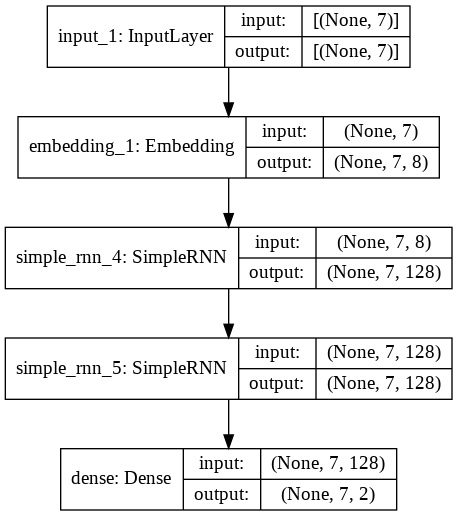

In [30]:
# 모델 생성
model = build_model(len(word_to_id), 8, 7, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs)